## Entrenamiento de ResNet50 con data augmentation y 3 modelos

Se procede al particionado de datos de train y valid por separado para aplicar data augmentation en entrenamiento mediante la librería imgaug. Luego, se proceden a realizar un modelo de clasificación binaria para discriminar primero el tipo de enfermedad, y posteriormente, se creará un modelo específico para enfermedades cancerígenas y no cancerígenas.

Comenzamos por la importación de librerías

In [1]:
# Librerías utilizadas por el script
import timm
import numpy as np
import pandas as pd
import cv2
import torch
import fastbook
import fastai
import fastcore
import PIL
import shutil

import matplotlib.pyplot as plt
import imgaug as ia
import seaborn as sns

from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from fastai.vision.all import *
from nbdev.showdoc import *
from fastai.vision.all import *

"""
!pip install -Uqq fastbook
!pip install nbdev
"""
fastbook.setup_book()
torch.cuda.is_available()

True

A continuación, se declaran las constantes usadas como parámetros a las funciones

In [2]:
# Número de clases. 2 para la binaria.
NUM_CLASSES = 2
TRAIN_DIR = "trainThumbnails/"
SEED = 19
# Número de canales de cada imagen
CHANNELS = 3
IMAGE_RESIZE = 386
RESIZE_METHOD = 'squish'
LOSS_FUNC = CrossEntropyLossFlat()
METRICS = [accuracy, BalancedAccuracy(), error_rate, Recall(), Precision()]

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 3

BATCH_SIZE = 16

train_aug = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

np.random.seed(SEED)

Ahora, podemos volver a calcular la proporción:

bin
Benign       35664
Malignant    29256
Name: count, dtype: int64


<Axes: xlabel='bin', ylabel='count'>

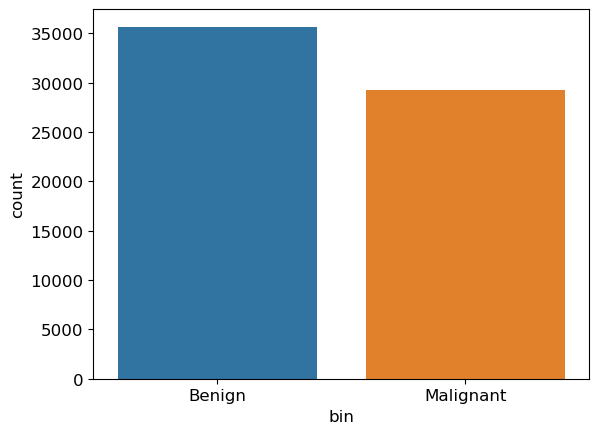

In [3]:
print(train_aug.bin.value_counts())

sns.countplot(data=train_aug, x='bin', order=train_aug.bin.value_counts().index)

Creamos el dataset. Para ello, me ayudaré de fastai y crearé un conjunto de imágenes que se usarán para train y test. Nota: hay dos columnas de etiquetas, por lo que se han hecho dos funciones distintas; una que se ocupa de las etiquetas binarias, y otra de las subcategorías. Comenzaremos primero por clasificación binaria, teniendo cuidado de no introducir imágenes aumentadas en validación.

In [4]:
def binary_label_train(fname):
    global train_aug
    el = train_aug.loc[train_aug['image'] == str(fname).split("/")[2]]
    return el['bin'].values[0]

def binary_label_valid(fname):
    global valid
    el = valid.loc[valid['image'] == str(fname).split("/")[2]]
    return el['bin'].values[0]


def multi_label(fname):
    global train_df
    el = train_df.loc[train_df['image'] == str(fname)]
    return ((el['label'].values[0]))

In [5]:
train_ds = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    get_y=binary_label_train,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(IMAGE_RESIZE, method=RESIZE_METHOD)],  # Redimensionado
    batch_tfms=Normalize.from_stats(*imagenet_stats)
).dataloaders("binAUG/train", bs=BATCH_SIZE)

In [6]:
valid_ds = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    get_y=binary_label_valid,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(IMAGE_RESIZE, method=RESIZE_METHOD)],  # Redimensionado
    batch_tfms=Normalize.from_stats(*imagenet_stats)
).dataloaders("binAUG/valid", bs=BATCH_SIZE)

Ahora, construimos un objeto dataloaders y creamos el objeto final apto para entrenamiento

In [7]:
dataset = DataLoaders(train_ds, valid_ds)

In [8]:
resnet50 = vision_learner(train_ds, 'resnet50', loss_func=LOSS_FUNC, metrics=METRICS, pretrained=True)
print(resnet50.summary())

/home/cristhian/anaconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853099/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Sequential (Input shape: 16 x 3 x 386 x 386)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 64 x 193 x 193 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 97 x 97   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                  

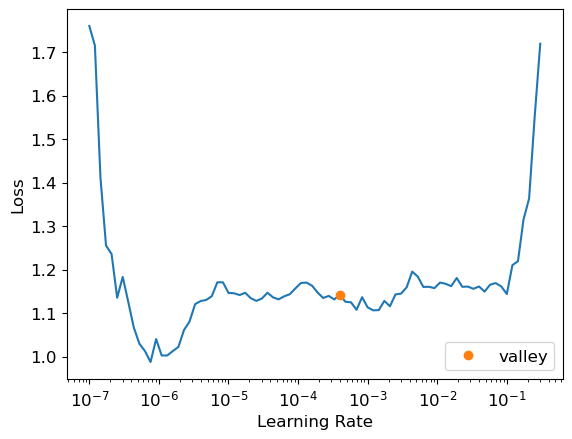

In [9]:
lrs = resnet50.lr_find()

In [10]:
# Creamos callbacks para el modelo
early_stopping = EarlyStoppingCallback(monitor='valid_loss', patience=EARLY_STOP_PATIENCE)
save_callback = SaveModelCallback(monitor='valid_loss', fname='best_model_augmented')
callbacks = [early_stopping, save_callback,ShowGraphCallback]


Procedemos a realizar el finetuning. Para ello, primero se entrenará solo la head de la red, y posteriormente, la red en su conjunto. Se usará early stopping con patience=3

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,error_rate,recall_score,precision_score,time
0,0.625073,0.426648,0.818546,0.812271,0.181454,0.752279,0.826810,08:18
1,0.579607,0.394189,0.831716,0.824325,0.168284,0.753656,0.853331,08:06
2,0.608216,0.387255,0.836799,0.827672,0.163201,0.740409,0.875865,07:47
3,0.510384,0.365335,0.840188,0.837940,0.159812,0.816446,0.824818,07:33
4,0.495390,0.355338,0.846041,0.837147,0.153959,0.752107,0.886815,07:43
5,0.440031,0.338864,0.848583,0.842396,0.151417,0.783244,0.865754,07:44
6,0.433418,0.330436,0.851972,0.847093,0.148028,0.800447,0.859280,07:30
7,0.393725,0.323256,0.856747,0.853778,0.143253,0.825391,0.850257,07:28
8,0.403484,0.316067,0.860136,0.854125,0.139864,0.796663,0.879582,07:28
9,0.336240,0.310645,0.860521,0.855500,0.139479,0.807500,0.871519,06:53


Better model found at epoch 0 with valid_loss value: 0.4266480505466461.


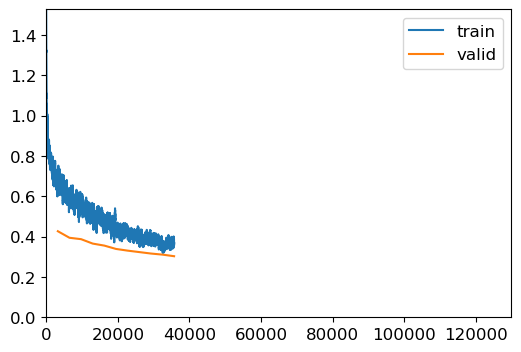

Better model found at epoch 1 with valid_loss value: 0.39418861269950867.
Better model found at epoch 2 with valid_loss value: 0.38725459575653076.
Better model found at epoch 3 with valid_loss value: 0.36533477902412415.
Better model found at epoch 4 with valid_loss value: 0.3553382158279419.
Better model found at epoch 5 with valid_loss value: 0.33886444568634033.
Better model found at epoch 6 with valid_loss value: 0.33043619990348816.
Better model found at epoch 7 with valid_loss value: 0.3232555091381073.
Better model found at epoch 8 with valid_loss value: 0.31606706976890564.
Better model found at epoch 9 with valid_loss value: 0.3106450140476227.
Better model found at epoch 10 with valid_loss value: 0.3027655780315399.


KeyboardInterrupt: 

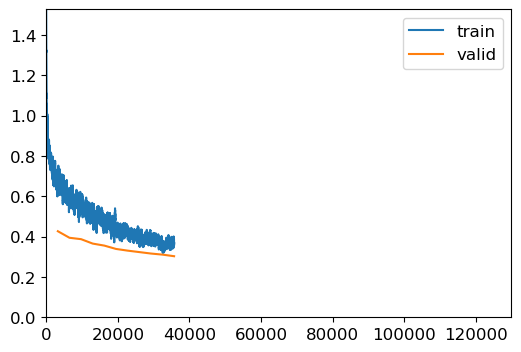

In [11]:
# FINETUNING
## Hiperparámetros
FREEZE_EPOCHS = 40
lr_mult=100
base_lr = lrs[0]/2

# Congelamos
resnet50.freeze()
resnet50.fit_one_cycle(FREEZE_EPOCHS, lrs[0], pct_start=0.99, cbs= callbacks)

In [ ]:
# Descongelamos y finalizamos entrenamiento
resnet50.unfreeze()
resnet50.fit_one_cycle(NUM_EPOCHS, slice(base_lr/lr_mult, base_lr), cbs= callbacks)

In [ ]:
resnet50.summary()

In [ ]:
state = torch.load('models/best_model_augmented.pth')
preds, targets = resnet50.get_preds(ds_idx=1)  # ds_idx=1 para el conjunto de validación


In [ ]:
y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

In [ ]:
print(classification_report(y_true, y_pred, target_names=train_ds.vocab))

In [ ]:
torch.save(resnet50, 'modeloentero.pth')

## ONNX

Convertimos al formato estándar

In [ ]:
resnet50.export()
resnet50.path

In [ ]:
testmodel = torch.load('export.pkl')
model_dict = testmodel.state_dict()
torch.save(model_dict, 'miModelo.pth')

In [ ]:
loaded_model = models.resnet50
loaded_model = vision_learner(trainSet, 'resnet50', loss_func=LOSS_FUNC,
                              metrics=METRICS)  # Crea un modelo vacío con la misma arquitectura
loaded_model.load_state_dict(torch.load('miModelo.pth'))

In [ ]:
type(loaded_model)

In [ ]:
class InferenceWrapper(nn.Module):
    def __init__(self, model, normalize_mean, normalize_std, scale_inp=False, channels_last=False):
        super().__init__()
        self.model = model
        self.register_buffer("normalize_mean", normalize_mean)
        self.register_buffer("normalize_std", normalize_std)
        self.scale_inp = scale_inp
        self.channels_last = channels_last
        self.softmax = nn.Softmax(dim=1)

    def preprocess_input(self, x):
        if self.scale_inp:
            x = x / 255.0

        if self.channels_last:
            x = x.permute(0, 3, 1, 2)

        x = (x - self.normalize_mean) / self.normalize_std
        return x

    def forward(self, x):
        x = self.preprocess_input(x)
        x = self.model(x)
        x = self.softmax(x)
        return x

In [ ]:
# Define the normalization mean and standard deviation
"""mean_tensor = torch.tensor(imagenet_stats[0]).view(1, 3, 1, 1)
std_tensor = torch.tensor(imagenet_stats[1]).view(1, 3, 1, 1)

# Set the model to evaluation mode
resnet50.eval()

# Wrap the model with preprocessing and post-processing steps
wrapped_model = InferenceWrapper(model,
                                 mean_tensor,
                                 std_tensor,
                                 scale_inp=False,  # Scale input values from the rang [0,255] to [0,1]
                                 channels_last=False,  # Have the model expect input in channels-last format
                                 )"""

In [ ]:
resnet50.load('best_model_augmented')

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# https://pytorch.org/vision/stable/models.html

pytorch_model = resnet50.model.eval()  # gets the PyTorch model
softmax_layer = torch.nn.Softmax(dim=1)  # define softmax
normalization_layer = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])  # normalization layer

# assembling the final model
final_model = nn.Sequential(
    normalization_layer,
    pytorch_model,
    softmax_layer
)

NameError: name 'resnet50' is not defined

In [1]:
input = torch.randn(BATCH_SIZE, 3, IMAGE_RESIZE, IMAGE_RESIZE).to('cuda')
torch.onnx.export(
    final_model,
    input,
    'modelbase.onnx',
    do_constant_folding=True,
    export_params=True,
    input_names=['input','input2'],
    output_names=['output'],
    opset_version=17,
    dynamic_axes={'input': {0: 'batch_size'},  # variable length axes
                  'output': {0: 'batch_size'}}
)

NameError: name 'torch' is not defined

Inferimos en ONNX

In [ ]:
from PIL import Image


def image_transform_onnx(path: str, size: int) -> np.ndarray:
    '''Image transform helper for onnx runtime inference.'''

    image = Image.open(path)
    image = image.resize((size, size))

    # now our image is represented by 3 layers - Red, Green, Blue
    # each layer has a 224 x 224 values representing
    image = np.array(image)

    # dummy input for the model at export - torch.randn(1, 3, 224, 224)
    image = image.transpose(2, 0, 1).astype(np.float32)

    # our image is currently represented by values ranging between 0-255
    # we need to convert these values to 0.0-1.0 - those are the values that are expected by our model
    image /= 255
    image = image[None, ...]
    return image

In [ ]:
import numpy as np
import onnxruntime as rt

labels = ['Benign', 'Malignant']

# get image as tensor - 1 x 3 x 256 x 256 dimensions
img = image_transform_onnx('trainThumbnails/ISIC_0068761.JPG', 386)

# initialize onnx runtime inference session
sess = rt.InferenceSession('modelbase.onnx')

# input & output names
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# input dimensions (important for debugging)
input_dims = sess.get_inputs()[0].shape

print(f"Input layer name: {input_name}, Output layer name: {output_name}, Input Dimension: {input_dims}")

results = sess.run([output_name], {input_name: img})[0]
print(f"It's a {labels[np.argmax(results)]}", results)